# Case Study Data Scientist for Product

## Note
This test assignment was given to me at the second stage of thes interview with one of the German companies. It followed by one hour discussion. I have successfully passed it and was offered a job position. 

## The data

We provide you some dummy data to provide an AB test analysis on. Even though the data is synthetically generated, it is representative of what we are dealing with in reality. However in this case study we anaylze only a tiny subset of metrics we are interested in and the amount of data provided is only a fraction of what we are actually working with.

We consider a hypothetical AB test setup which resulted in the data you find in [data/session_data.csv](./data).

The fields in that csv file are:

- *session_id*: unique identifier of a user session.
- *variant_id*: identifier of the test group the session was assigned to. Values are 0 and 1. A value of 0 means the session was assigned to the control group, i.e. the user was provided the status quo of our website, without the new feature added. A value of 1 means the session was assigned to the test group, i.e. the new feature was activated. It may be helpful to illustrate this with a naive example: If the feature corresponds to change of the color of a button on the website from blue to green, then all sessions with variant_id 0 will see a blue button, while all sessions with variant_id 1 see a green button.
- *conversion*: Identifies if a session resulted in a subscription by the user. 0 means no subscription, 1 means the user subscripbed within the session.
- *characters_translated*: Total number of characters the user has translated within the session.

## Your tasks

1. Based on the data described in the previous section, we ask you to provide a manual analysis of the data. Imagine the following szenario: We have run the AB test for a while and provide you with the data we collected so far in order to suggest an action point to your Data Science Colleagues. Is it helping our business and we should accept it (i.e. release it as the new default)? Should we reject it? Should we extend the testing period? 

    As mentioned above, our production code for AB testing is based on Python. Therefore we would like you to use Python for your solution of this task (preferably Python 3). All your code should be placed within this directory.
    In terms of presentation of results, we use Jupyter Notebook for our analyses since it also works great for providing a presentation of the results to techincal colleagues along with the code. If you prefer something else, that's also fine. What's important to us is that we can easily follow your thinking and conclusions and your code is well comprehensible. Please provide all the code that is required to perform your analysis.
    As a guideline: If you are comfortable with the topic of AB testing this task can be completed within one or two hours. 

    For Bonus Points: In the file [INSTRUCTIONS.md](./INSTRUCTIONS.md), please provide instructions for us in order to execute the code you provided in order to reproduce your analysis. If you like it's fine to base this on a tool like Anaconda, poetry, Docker, make, etc.. Main aspect is that it should be easy for us to reproduce your results.


2. So far we looked at 2 metrics. Which 3 other metrics would you include in the analysis to measure the impact of a change? Please give reasons for your choice. You can provide your answer in the file [task2.txt](./task2.txt).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import norm, chi2_contingency, chi2


In [2]:
# Load the data
data_path = './data/session_data.csv'
df = pd.read_csv(data_path)
df.columns = ['Session_ID', 'Variant_ID', 'Conversion', 'Characters_Translated']
df.head()

,Session_ID,Variant_ID,Conversion,Characters_Translated
0,MSLAOFLDF,1,0,725
1,UGUAXDOAT,1,0,66
2,FLKCLRVYV,0,0,11
3,QJXUYKXRI,0,0,209
4,SIHLAZXVF,0,0,1


# Exploratory Data Analysis

In [3]:
print('Size: ', df.shape, '\n')

print('Basic info')
print(df.info(), '\n')

Size:  (1000000, 4) 

Basic info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Session_ID             1000000 non-null  object
 1   Variant_ID             1000000 non-null  int64 
 2   Conversion             1000000 non-null  int64 
 3   Characters_Translated  1000000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 30.5+ MB
None 



Session_ID is not a user ID, all unique. If we had User_ID instead, it would be of big interest to look at the
duplicates, i.e. how conversion depends on number of sessions and translated characters.

In [4]:
# Session_ID is not a user ID, all unique.
set(df.Session_ID.value_counts().tolist())

{1}

### Number of translated characters

Let us look at the number of translated characters.

In [5]:
# Control group 

df_A = df[df.Variant_ID==0]

num_sessions = df_A.Conversion.value_counts()
avg_char = df_A.groupby('Conversion').Characters_Translated.mean()
std_char = df_A.groupby('Conversion').Characters_Translated.std()

df_A_obs = {'Version':[0,0], 'Conversion':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_A_obs = pd.DataFrame(df_A_obs)

df_A_obs.style.hide_index()

Version,Conversion,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
0,0,494584,377.485634,4581.837332
0,1,5444,394.949486,2368.599878


In [6]:
# Test group 

df_B = df[df.Variant_ID==1]

num_sessions = df_B.Conversion.value_counts()
avg_char = df_B.groupby('Conversion').Characters_Translated.mean()
std_char = df_B.groupby('Conversion').Characters_Translated.std()

df_B_obs = {'Version':[1,1], 'Conversion':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_B_obs = pd.DataFrame(df_B_obs)

df_B_obs.style.hide_index()

Version,Conversion,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
1,0,494351,337.540584,2236.503086
1,1,5621,338.139121,1993.110579


In [7]:
df[df.Conversion==0].Characters_Translated.describe()

count    9.889350e+05
mean     3.575178e+02
std      3.605532e+03
min      0.000000e+00
25%      9.000000e+00
50%      4.600000e+01
75%      1.940000e+02
max      2.328264e+06
Name: Characters_Translated, dtype: float64

In [8]:
df[df.Conversion==1].Characters_Translated.describe()

count     11065.000000
mean        366.089923
std        2186.012537
min           0.000000
25%           8.000000
50%          45.000000
75%         188.000000
max      115207.000000
Name: Characters_Translated, dtype: float64

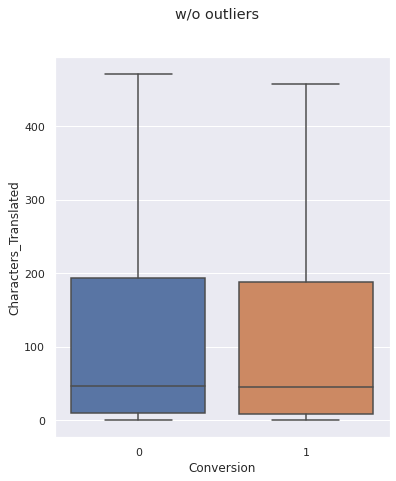

In [9]:
# without outliers

_, axes = plt.subplots(1, 1, sharey=True, figsize=(6, 7))
plt.suptitle('w/o outliers')
sns.boxplot(x = 'Conversion', y='Characters_Translated', data=df, showfliers=False);

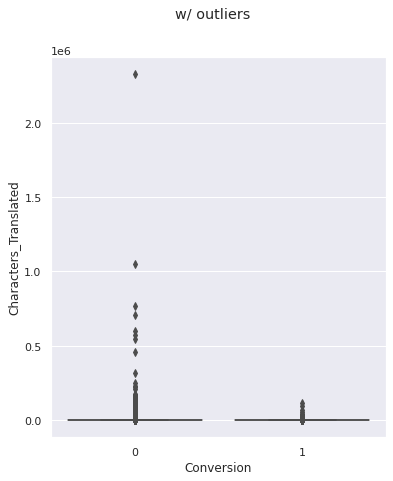

In [10]:
# with outliers

_, axes = plt.subplots(1,1, sharey=True, figsize=(6, 7))
plt.suptitle('w/ outliers')
sns.boxplot(x='Conversion', y='Characters_Translated', data=df, showfliers=True);


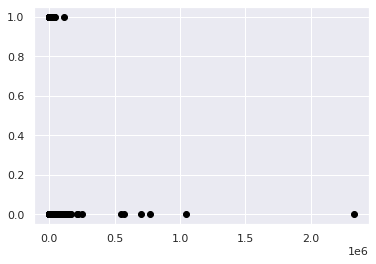

In [11]:
# Translated characters vs. conversion: control group only

X = np.array([[x] for x in df_A.Characters_Translated.tolist()])
y = np.array(df_A.Conversion.tolist())
plt.scatter(X, y,  color='black')

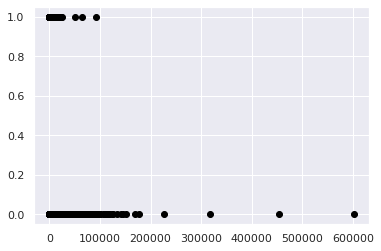

In [12]:
# Translated characters vs. conversion: test group only

X = np.array([[x] for x in df_B.Characters_Translated.tolist()])
y = np.array(df_B.Conversion.tolist())
plt.scatter(X, y,  color='black')

### Conclusion

There is an explicit set of outliers. The outliers represent a group with the big and huge amount of translated characters. I suppose that these users are not interested in subscribing at all, they probably need to translate a big document once (or several times) so they use a free trial period. 

I know that the free translation is limited by 5000 characters, so in this dataset it is a question for me how those users without subscription can translate more then 100k symbols (and even 600k). I suppose that a free trial period isn't counted as conversion, so my assumption makes sense.

However, to test this hypothesis I would need more data: user_id column is missing. 

Let us perform the analyzis for both cases, assuming first that the hypothesis is false and keeping the outliers.

# Analyzis with outliers

Since there is not enough information, we suppose that the outliers do not represent the noise and consider them as part of the data.

### Conversion

In [13]:
# Summarize the data

num_sessions = df.Variant_ID.value_counts()
converted_obs = df.groupby('Variant_ID').Conversion.sum()

df_obs = {'Version':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
      'Converted':[converted_obs[0],converted_obs[1]]}
df_obs = pd.DataFrame(df_obs)
df_obs['Not_Converted'] = df_obs.Num_Sessions - df_obs.Converted

df_obs.style.hide_index()

Version,Num_Sessions,Converted,Not_Converted
0,500028,5444,494584
1,499972,5621,494351


We would like to see whether the "Conversion" depends on "Version". The null and the alternative hypothesis are:

$H_0$: the CR is the same for both versions,

$H_a$: the CR is higher for the version 1.

To test the results for significance, we perform [Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) - "a test of independence assesses whether observations consisting of measures on two variables, expressed in a contingency table, are independent of each other".

The procedure is based on the [Pearson's theorem](https://ocw.mit.edu/courses/mathematics/18-443-statistics-for-applications-fall-2003/lecture-notes/lec23.pdf) and can be summarized as follows:
- calculate the chi-squared test statistic, which is a normalized sum of squared deviations between observed and theoretical (estimated) frequencies $\chi^2 = \sum\limits_i\dfrac{(O_i-E_i)^2}{E_i}$;
- under the null hypothesis it converges in distribution to chi-square distribution with 1 (in our case) degree of freedom;
- calculate the $p$-value which encodes how likely is it to get the observed results if the null hypothesis $H_0$ is true; 
- choose a confidence interval and compare it with the $p$-value; based on this one can judge whether the null hypothesis can be rejected.

Luckily, this procedure is implemented in scipy.stats package.

In [14]:
cont_table_observed = np.array([df_obs.Converted.tolist(), df_obs.Not_Converted.tolist()]).T
test_result = chi2_contingency(cont_table_observed,correction=False)
p_val = test_result[1]
print(p_val)

0.08951239802494876


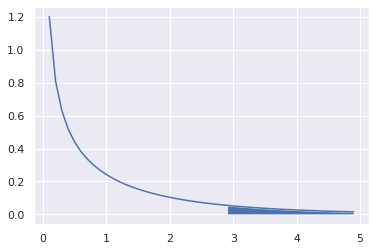

In [15]:
test_statistic = test_result[0]

x = np.arange(0, 5, 0.1)
plt.plot(x, chi2.pdf(x, df=1))
plt.fill_between(x[x>test_statistic], chi2.pdf(x[x>test_statistic], df=1))
plt.show()

### Conclusion

We see that with the standard 95% confidence interval, the observed data are not statistically significant and the Null hypothesis cannot be rejected (the $p$-value p > 0.05).

### Number of translated charachters


In [16]:
df.head()

,Session_ID,Variant_ID,Conversion,Characters_Translated
0,MSLAOFLDF,1,0,725
1,UGUAXDOAT,1,0,66
2,FLKCLRVYV,0,0,11
3,QJXUYKXRI,0,0,209
4,SIHLAZXVF,0,0,1


In [17]:
# Summarize the data

num_sessions = df.Variant_ID.value_counts()
avg_char = df.groupby('Variant_ID').Characters_Translated.mean()
std_char = df.groupby('Variant_ID').Characters_Translated.std()

df_obs = {'Version':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_obs = pd.DataFrame(df_obs)

df_obs.style.hide_index()

Version,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
0,500028,377.675770,4563.523276
1,499972,337.547313,2233.912329


Here we would like to test the null hypothesis

$H_0$: the average number of translated characters is the same for version 0 and 1; and the alternative is

$H_a$: the average number of translated characters is greater for version 0 than 1.

Since we are dealing with very big sample size, and the outcome is a continues r.v., it is straightforward to implement the $Z$-test. 

The CLT claims, that under the null hypothesis $Z = \dfrac{\mu_0-\mu_1}{\sqrt{\dfrac{\sigma_0^2}{n_0} + \dfrac{\sigma_1^2}{n_1}}} \to \mathcal{N}(0,1)$

Let's calculate the $Z$-statistic and the corresponding $p$-value

In [18]:
def Z_test_two_sample(mean, std, n, test = 'right'):
    
    Z = (mean[1] - mean[0])/np.sqrt(std[0]**2/n[0] + std[1]**2/n[1])
    if test == 'left':
        Z=-Z
    p_val = norm.sf(Z)
    if test == 'two_sided':
        p_val=p_val*2
        
    return Z, p_val

mean = df_obs.Avg_Characters_Translated.tolist()
std = df_obs.Std_Characters_Translated.tolist()
sample_size = df_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'left')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 5.584695954384107
p-value: 1.1705471007470975e-08


### Conclusion

The $p$-value is very small, so the Null hypothesis is rejected and one can claim that on average the number of translated symbols is greater for the version 0.


### Number of translated characters vs. Conversion

One can assume, that there is correlation between number of characters and conversion, i.e., users who translate less do not convert. If so, this ends up in filtering the data which reduces computational time and reduce noise. Let us investigate this question in more details.

We see that there is no such a big difference. Let us test this hypotheis.

We perform the Z-test:

$H_0$: Converted and non-converted users translate the same amount of characters on average

In [19]:
# control group

mean = df_A_obs.Avg_Characters_Translated.tolist()
std = df_A_obs.Std_Characters_Translated.tolist()
sample_size = df_A_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'right')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 0.533141805272148
p-value: 0.2969677110199322


In [20]:
# test group

mean = df_B_obs.Avg_Characters_Translated.tolist()
std = df_B_obs.Std_Characters_Translated.tolist()
sample_size = df_B_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'right')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 0.022355273976680815
p-value: 0.4910822788110893


### Conclusion

The p-values are within the confidence interval and we cannot reject the null hypothesis.


## Discussion

Analyzis shows that there is no significant evidence to choose one version over another one. 

Let us perform the same analysis with the outliers removed.

# Analyzis without outliers

Since there is not enough information, we suppose that the outliers represent the users who are interested in translating a single document (they might sign up for a free trial and then cancel the subscription). I also assume that the free trial period is not counted as conversion.

Assume that the hypothesis is true and remove the outliers since they represent the noise.

### Remove the outliers

To remove the outliers we use 1.5 IQR rule.

Of course this will remove a lot of converted sessions, so another option would be to play with the threshold. However, let us leave this outside of this assignment.

In [21]:
Q1 = df.Characters_Translated.quantile(0.25)
Q3 = df.Characters_Translated.quantile(0.75)
IQR = Q3 - Q1

df_clean = df[df.Characters_Translated < Q3+1.5*IQR]

In [22]:
df_clean[df_clean.Conversion==1].Characters_Translated.describe()

count    9696.000000
mean       78.325083
std       104.275212
min         0.000000
25%         7.000000
50%        31.000000
75%       108.000000
max       471.000000
Name: Characters_Translated, dtype: float64

Now, let us repeat the analyzis performed above.

### Conversion

In [23]:
df = df_clean.copy()

In [24]:
# Summarize the data

num_sessions = df.Variant_ID.value_counts()
converted_obs = df.groupby('Variant_ID').Conversion.sum()

df_obs = {'Version':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
      'Converted':[converted_obs[0],converted_obs[1]]}
df_obs = pd.DataFrame(df_obs)
df_obs['Not_Converted'] = df_obs.Num_Sessions - df_obs.Converted

df_obs.style.hide_index()

Version,Num_Sessions,Converted,Not_Converted
0,434365,4762,429603
1,438948,4934,434014


In [25]:
cont_table_observed = np.array([df_obs.Converted.tolist(), df_obs.Not_Converted.tolist()]).T
test_result = chi2_contingency(cont_table_observed,correction=False)
p_val = test_result[1]
print(p_val)

0.21611930873485474


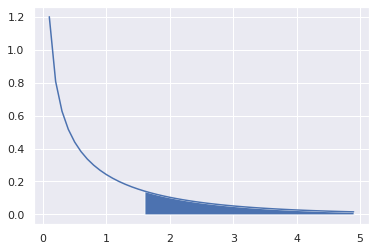

In [26]:
test_statistic = test_result[0]

x = np.arange(0, 5, 0.1)
plt.plot(x, chi2.pdf(x, df=1))
plt.fill_between(x[x>test_statistic], chi2.pdf(x[x>test_statistic], df=1))
plt.show()

### Conclusion

We see that with the standard 95% confidence interval, the observed data are not statistically significant and the Null hypothesis cannot be rejected (the $p$-value p > 0.05).

### Number of translated charachters


In [27]:
df.head()

,Session_ID,Variant_ID,Conversion,Characters_Translated
1,UGUAXDOAT,1,0,66
2,FLKCLRVYV,0,0,11
3,QJXUYKXRI,0,0,209
4,SIHLAZXVF,0,0,1
5,FGJDXOTWQ,1,0,49


In [28]:
# Summarize the data

num_sessions = df.Variant_ID.value_counts()
avg_char = df.groupby('Variant_ID').Characters_Translated.mean()
std_char = df.groupby('Variant_ID').Characters_Translated.std()

df_obs = {'Version':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_obs = pd.DataFrame(df_obs)

df_obs.style.hide_index()

Version,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
0,434365,81.250303,106.223840
1,438948,78.443984,105.009417


In [29]:
def Z_test_two_sample(mean, std, n, test = 'right'):
    
    Z = (mean[1] - mean[0])/np.sqrt(std[0]**2/n[0] + std[1]**2/n[1])
    if test == 'left':
        Z=-Z
    p_val = norm.sf(Z)
    if test == 'two_sided':
        p_val=p_val*2
        
    return Z, p_val

mean = df_obs.Avg_Characters_Translated.tolist()
std = df_obs.Std_Characters_Translated.tolist()
sample_size = df_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'left')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 12.414620650824036
p-value: 1.088581638067789e-35


### Conclusion

The $p$-value is very small, so the Null hypothesis is rejected and one can claim that on average the number of translated symbols is greater for the version 0.


### Number of translated characters vs. Conversion

One can assume, that there is correlation between number of characters and conversion, i.e., users who translate less do not convert. If so, this ends up in filtering the data which reduces computational time and reduce noise. Let us investigate this question in more details.

We see that there is no such a big difference. Let us test this hypotheis.

We perform the Z-test:

$H_0$: Converted and non-converted users translate the same amount of characters on average

In [30]:
# Control group 

df_A = df[df.Variant_ID==0]

num_sessions = df_A.Conversion.value_counts()
avg_char = df_A.groupby('Conversion').Characters_Translated.mean()
std_char = df_A.groupby('Conversion').Characters_Translated.std()

df_A_obs = {'Version':[0,0], 'Conversion':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_A_obs = pd.DataFrame(df_A_obs)

df_A_obs.style.hide_index()

Version,Conversion,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
0,0,429603,81.276993,106.247177
0,1,4762,78.842503,104.079702


In [31]:
# Test group 

df_B = df[df.Variant_ID==1]

num_sessions = df_B.Conversion.value_counts()
avg_char = df_B.groupby('Conversion').Characters_Translated.mean()
std_char = df_B.groupby('Conversion').Characters_Translated.std()

df_B_obs = {'Version':[1,1], 'Conversion':[0, 1], 'Num_Sessions':[num_sessions[0], num_sessions[1]],
          'Avg_Characters_Translated':[avg_char[0],avg_char[1]],
          'Std_Characters_Translated':[std_char[0],std_char[1]]}
df_B_obs = pd.DataFrame(df_B_obs)

df_B_obs.style.hide_index()

Version,Conversion,Num_Sessions,Avg_Characters_Translated,Std_Characters_Translated
1,0,434014,78.451013,105.015613
1,1,4934,77.825699,104.471677


In [32]:
# Control group

mean = df_A_obs.Avg_Characters_Translated.tolist()
std = df_A_obs.Std_Characters_Translated.tolist()
sample_size = df_A_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'left')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 1.6048804745567282
p-value: 0.05426005565525261


In [33]:
# Test group

mean = df_B_obs.Avg_Characters_Translated.tolist()
std = df_B_obs.Std_Characters_Translated.tolist()
sample_size = df_B_obs.Num_Sessions.tolist()

Z, p_val = Z_test_two_sample(mean, std, sample_size, 'left')

print("Z-score: {0}\np-value: {1}".format(Z, p_val))

Z-score: 0.41804104089627725
p-value: 0.337958555466499


### Conclusion

The p-values are within the confidence interval and we cannot reject the null hypothesis.


# Summary

<b> Regardless of presence of outliers </b> , the analyzis shows that there is no significant evidence to choose one version over the other. 

One has to perform a new experiment with more data (other metrics and information such as user ids).

When designing a new experiment, the traffic should be taken into account. It is hard to judge based on the data provided, whether one should wait longer or not. The number of conversions seems to be big enough, so I would suggest to test another version. Before the test one also should prioritize (using heatmap for example) what is relevant for testing.